In [1]:
import csv
import numpy as np
import ROOT as rt
from glob import glob
import os
import uproot

from histo_utilities import create_TH1D, create_TH2D


donotdelete = []

Welcome to JupyROOT 6.22/08


# load ROOT files

In [65]:
f = {}
calibration = {}
# f['output'] = '/Users/christinawang/Desktop/Caltech/Research/DM/data/20210309/output_runAll_converted.root'
# date = '/20210313/'

date = '/20210906/'
# # channel 1 Lyso DUT
if '20210830' in date:
    f['target_co57'] = '/Users/christinawang/Desktop/Caltech/Research/DM/data/hpge/'+date+'/output_Co57_Target_run1-20_converted.root'
    f['tag_co57'] = '/Users/christinawang/Desktop/Caltech/Research/DM/data/hpge/'+date+'/output_Co57_Tag_run21-40_converted.root'
    #20210830 from gaus_amp to energy
    calibration['target'] = [0.063, 3.526] #p1, p0 / slope, y-intercept
    calibration['tag'] = [0.056, 4.091] #p1, p0 / slope, y-intercept

if '20210906' in date:
    f['target_co57'] = '/Users/christinawang/Desktop/Caltech/Research/DM/data/hpge/'+date+'/output_Co57Calib_DUT_run1_20_converted.root'
    f['tag_co57'] = '/Users/christinawang/Desktop/Caltech/Research/DM/data/hpge/'+date+'/output_Co57Calib_TAG_run21_40_converted.root'
    #20210830 from gaus_amp to energy
    calibration['target'] = [0.03117, 0.028 ] #p1, p0 / slope, y-intercept
    calibration['tag'] = [0.0582, 0.025] #p1, p0 / slope, y-intercept





calib = 1

plot_path = '/Users/christinawang/Desktop/Caltech/Research/DM/plots/'+date
if not os.path.isdir(plot_path):os.makedirs(plot_path)
# Amp_x_R = 1e-9*(1.0/50.0) * 1e12 # nV to pC
peaks_pc = {}
tree = {}
h = {}
gaus_amp = {}
gaus_mean = {}
gaus_sigma = {}
gaus_chi2 = {}
baseline_RMS = {}

for k,v in f.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['pulse']
    a = np.array(tree[k]["i_evt"])
    gaus_amp[k] = np.array(tree[k]["gaus_amp"]) # in mV
    gaus_mean[k] = np.array(tree[k]["gaus_mean"]) # in ns
    gaus_sigma[k] = np.array(tree[k]["gaus_sigma"]) # in ns
    baseline_RMS[k] = np.array(tree[k]["baseline_RMS"]) # in mV





    if calib:
        if 'target' in k:gaus_amp[k] = gaus_amp[k]*calibration['target'][0]+calibration['target'][1]
        elif 'tag' in k:gaus_amp[k] = gaus_amp[k]*calibration['tag'][0]+calibration['tag'][1]
#     else: integral[k] = integral[k]*calibration['ch3_NaI'][0]+calibration['ch3_NaI'][1]
    baseline_RMS[k] = np.array(tree[k]["baseline_RMS"])
    print(gaus_amp[k].shape)

target_co57 /Users/christinawang/Desktop/Caltech/Research/DM/data/hpge//20210906//output_Co57Calib_DUT_run1_20_converted.root
(100000, 3)
tag_co57 /Users/christinawang/Desktop/Caltech/Research/DM/data/hpge//20210906//output_Co57Calib_TAG_run21_40_converted.root
(100000, 3)


In [16]:
def peak_finding(v,k):
    SS = rt.TSpectrum()
    n_pks = SS.Search(v, 0.1, "", 0.002)
    x_pos = SS.GetPositionX()
    y_pos = SS.GetPositionY()
    pks = []
    print (n_pks)
    for j in range(n_pks):
        if not j == 0:continue
        n_pk = v.FindBin(x_pos[j])
        if j == 0:
            thr = 0.4 * v.GetBinContent(n_pk)
        else:
            thr = 0.4 * v.GetBinContent(n_pk)
        n_low = n_pk
        while v.GetBinContent(n_low) > thr:
            n_low -= 1
        x_low = v.GetBinCenter(n_low)    
        n_up = n_pk
        while v.GetBinContent(n_up) > thr:
            n_up += 1
        x_up = v.GetBinCenter(n_up)
        r = v.Fit('gaus', 'LRSQ+', '', x_low, x_up)
        r = r.Get()
        print( 'Fit p-val = {:.2f}'.format(r.Prob()))
        print(k, 'number in nVs',r.Parameter(1), r.Parameter(2))




# plot Co57 peak

/usr/local/lib/python3.9/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_spectrum
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /Users/christinawang/Desktop/Caltech/Research/DM/plots//20210906/channel2_energy_calibration.png has been created


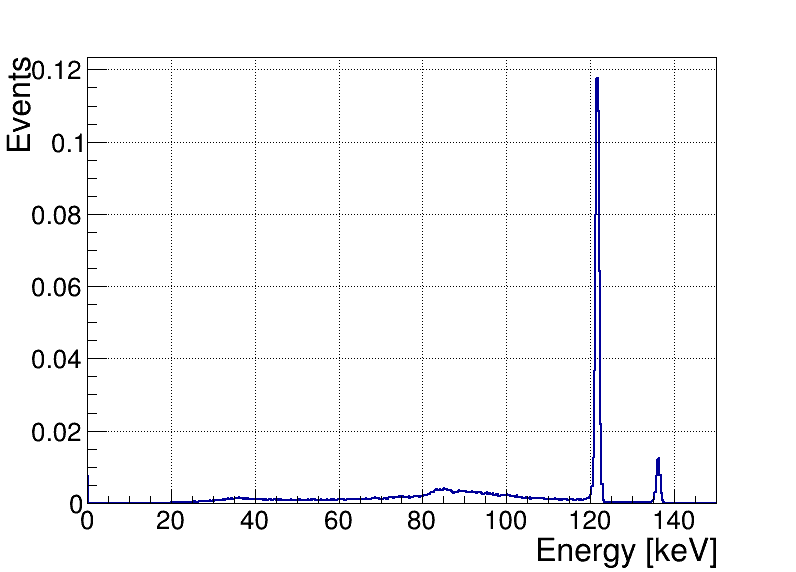

In [74]:

c = rt.TCanvas('c_spectrum', 'c_spectrum', 800, 600)
#rt.gStyle.SetOptFit(000002200)
# rt.gStyle.SetOptFit(000002200)
# rt.gStyle.SetTitleSize(0.8)
leg = rt.TLegend(0.15,0.65,0.4,0.9)
leg = rt.TLegend(0.65,0.65,0.9,0.9)


h = {}

i = 0
ch = 2
for k in tree.keys():
    if not 'tag' in k:continue
    if calib:
        bins = [500,0,150]
        xaxis = 'Energy [keV]'
    else: 
        if ch == 0:bins = [1000,3500,4500]
        else:bins = [500,0,2500]
        xaxis = 'Amplitude [mV]'
    h[k] = create_TH1D(gaus_amp[k][:,ch], binning = bins,axis_title = [xaxis, 'Events'])


    v = h[k]

    v.SetStats(0)
    v.SetTitle('')
    v.GetXaxis().SetTitleSize(0.06)
    v.GetXaxis().SetTitleOffset(0.9)
    v.GetXaxis().SetLabelSize(0.05)

    v.GetYaxis().SetTitleSize(0.06)
    v.GetYaxis().SetTitleOffset(0.9)
    v.GetYaxis().SetLabelSize(0.05)
    v.SetLineColor(i+1)
    v.SetLineWidth(2)
    v.Scale(1./v.Integral())



    v.DrawCopy('hist' if i == 0 else 'hist same')
#     peak_finding(v,k)


    leg.AddEntry(v,k)
    i+=1
c.SetLeftMargin(0.11)
c.SetBottomMargin(0.12)

# leg.Draw()
# c.SetLogy()
c.SetGrid()
c.Draw()
if calib: c.SaveAs(plot_path+'channel'+str(ch)+'_energy_calibration.png')
else: c.SaveAs(plot_path+'channel'+str(ch)+'_calibration.png')
donotdelete.append(c)

In [53]:
# gamma: 0.014 MeV (9.54 %) 0.122 MeV (85.6 %) 0.136 MeV (10.6 %) 0.692 MeV (0.02 %)

peaks = {}
peaks_err = {}
#20210830 [mV --> keV]
peaks['target'] = [0, 1887.04, 2110.03]
peaks['tag'] = [0, 2092.64, 2341.11]
peaks_err['target'] = [0, 5.20, 5.25]
peaks_err['tag'] = [0, 7.53, 6.76]
y_peak = [  0, 122, 136]

#20210906 [mV --> keV]
peaks['target'] = [0, 3904.7, 4370.3]
peaks['tag'] = [0, 2091.4, 2339.8]
peaks_err['target'] = [10.1, 10.1, 10.0]
peaks_err['tag'] = [7.4 ,7.4, 7.2]
y_peak = [  0, 122, 136]

In [54]:
gr_gain = {}
for k in peaks.keys():
    gr_gain[k] = rt.TGraphErrors(len(peaks[k]))
    for i in range(len(peaks[k])):
        gr_gain[k].SetPoint(int(i), peaks[k][i], y_peak[i])
        gr_gain[k].SetPointError(int(i), peaks_err[k][i],0.0)



****************************************
Minimizer is Minuit / Migrad
Chi2                      =     0.585482
NDf                       =            1
Edm                       =   3.1729e-11
NCalls                    =           25
p0                        =    0.0254844   +/-   0.429329    
p1                        =    0.0582036   +/-   0.00023551  

tag p-val = 0.444
 FCN=0.585482 FROM MIGRAD    STATUS=CONVERGED      24 CALLS          25 TOTAL
                     EDM=3.1729e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.54844e-02   4.29329e-01   1.51472e-04   9.66690e-06
   2  p1           5.82036e-02   2.35510e-04   8.30903e-08  -1.78454e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_gain


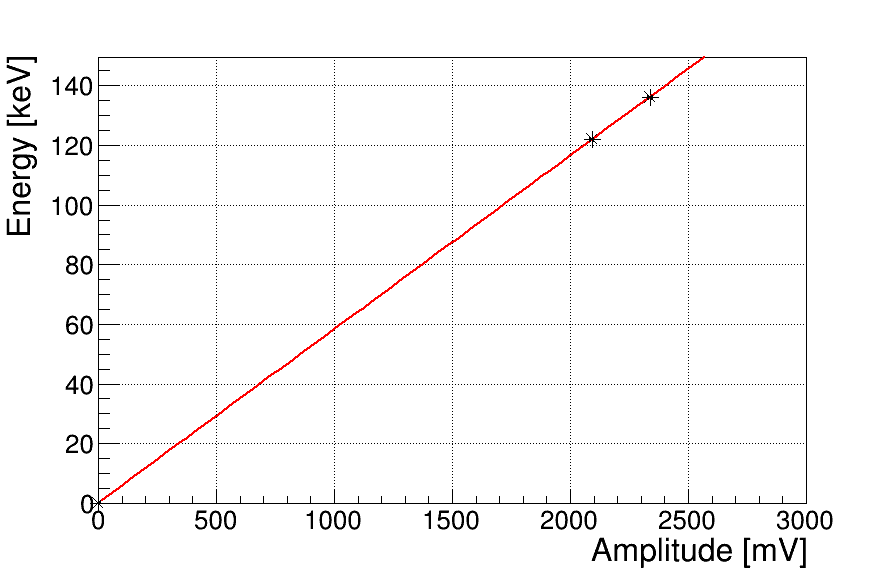

In [58]:
c_gain = rt.TCanvas('c_gain', 'c_gain', 900, 600)

for i, k in enumerate(gr_gain.keys()):
    if not i == 1:continue
    r = gr_gain[k].Fit('pol1', 'S')
    r = r.Get()
    print(r)
    print(k, 'p-val = {:.3f}'.format(r.Prob()))
    
    gr_gain[k].SetMarkerColor(1)
    gr_gain[k].SetMarkerSize(2)
    gr_gain[k].SetLineWidth(2)



#     gr_gain[k].Draw('AP*E1' if i== 0 else 'AP*E1 same')
    gr_gain[k].Draw('AP*E1')


    gr_gain[k].SetTitle("")
    gr_gain[k].GetXaxis().SetTitle('Amplitude [mV]')
    gr_gain[k].GetYaxis().SetTitle('Energy [keV]')
    gr_gain[k].GetYaxis().SetLimits(0,200)
    gr_gain[k].GetXaxis().SetLimits(0, 3000)
#     else:gr_gain[k].GetXaxis().SetLimits(0, 3000)


    gr_gain[k].GetXaxis().SetTitleSize(0.06)
    gr_gain[k].GetXaxis().SetTitleOffset(0.9)
    gr_gain[k].GetXaxis().SetLabelSize(0.05)

    gr_gain[k].GetYaxis().SetTitleSize(0.06)
    gr_gain[k].GetYaxis().SetTitleOffset(0.9)
    gr_gain[k].GetYaxis().SetLabelSize(0.05)

c_gain.SetLeftMargin(0.11)
c_gain.SetBottomMargin(0.12)

c_gain.SetGrid()
c_gain.Draw()

# rt.gStyle.SetOptFit(0)